#   Choosing a threshold value for classification and ROC

## Import libraries

In [417]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

from google.colab import files
import joblib

## Functions

In [418]:
def Calculate_Sensitivity_and_Specificity(predicted, true):
    tp = sum((p == 1 and t == 1) for p, t in zip(predicted, true))
    fp = sum((p == 1 and t == 0) for p, t in zip(predicted, true))
    tn = sum((p == 0 and t == 0) for p, t in zip(predicted, true))
    fn = sum((p == 0 and t == 1) for p, t in zip(predicted, true))

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    return sensitivity, specificity

In [419]:
def Sensitivity_Specificity_By_Threshold(classification_by_thresholds, true_calss):
  sensitivity_specificity_DataFrame = pd.DataFrame()
  for column in classification_by_thresholds.columns:
    classification = classification_by_thresholds[column]
    sensitivity_specificity_DataFrame[column] = Calculate_Sensitivity_and_Specificity(classification, true_calss)

  return sensitivity_specificity_DataFrame.rename(index={0: 'Sensitivity', 1: 'Specificity',})

In [420]:
def Classify_For_Specific_Threshold(probability, threshold):
  return np.where(probability > threshold, 1, 0)

In [421]:
def Classify_By_Threshold(probability, thresholds):
  classification_DataFrame = pd.DataFrame()
  for value in thresholds:
    # the round is to make the column names look good
    classification_DataFrame[str(round(value, 5))] = Classify_For_Specific_Threshold(probability, value)

  return classification_DataFrame

## Importing the dataset

In [422]:
training_file_name = 'Geometry and duck backward elimination with Support Vector Classification data' + '.csv'
data = pd.read_csv(training_file_name)

# The file is read with a column of indexes and this line removes it
data = data.drop(data.columns[0], axis=1)

## Choose an equal number of samples from each classes

In [423]:
# Split the data by classes
data_class_1 = data.loc[data['segmented'] == 1]
data_class_0 = data.loc[data['segmented'] == 0]

In [424]:
# Print class lenght
print('class 1 lenght:')
print(data_class_1.shape[0])

print('class 0 lenght:')
print(data_class_0.shape[0])

class 1 lenght:
6882
class 0 lenght:
15014


In [425]:
# Take n samples of each class - n depends on the amount of samples from each class
n_sampels = 6800
random_state = 7

data_class_1 = data_class_1.sample(n=n_sampels, random_state=random_state)
data_class_0 = data_class_0.sample(n=n_sampels, random_state=random_state)

In [426]:
# Connects the classes and mixes the data
data_equal = pd.concat([data_class_1, data_class_0], axis=0)
data_equal = data_equal.sample(frac=1.0, random_state=random_state)

In [427]:
# Remove the segmented image layer
X = np.array(data_equal.drop('segmented', axis=1))
y = np.array(data_equal['segmented'])

## Lode a model

In [428]:
model = 'LogisticRegression'
model_file_name = model  + '.pkl'
classfier = joblib.load(model_file_name)

## Threshold and AUC

In [429]:
# predict probability

probability = classfier.predict_proba(X)
probability_class_1 = probability[:,1]

In [430]:
# calculation of specificity and sensitivity for threshold values

steps = 0.01
sensitivity_specificity = Sensitivity_Specificity_By_Threshold(Classify_By_Threshold(probability_class_1, np.arange(0, 1 + steps, steps)), y)

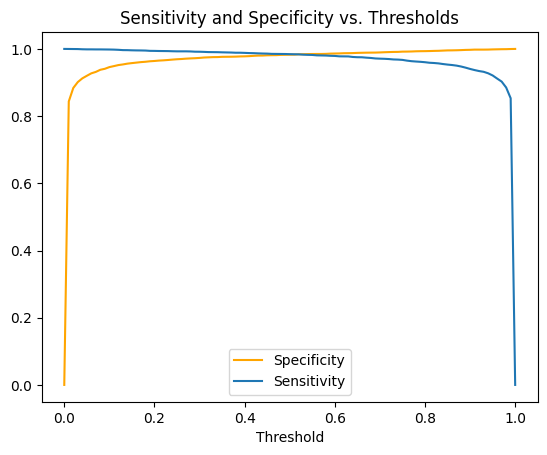

In [431]:
# plot the sensitivity and specificity vs. thresholds

specificity = np.array(sensitivity_specificity.loc[["Specificity"]]).reshape(-1)
sensitivity = np.array(sensitivity_specificity.loc[["Sensitivity"]]).reshape(-1)
thresholds = np.arange(0, 1 + steps, steps)

plt.figure()
plt.plot(thresholds, specificity, label= 'Specificity', color='orange')
plt.plot(thresholds, sensitivity, label= 'Sensitivity')

plt.xlabel('Threshold')
plt.title('Sensitivity and Specificity vs. Thresholds')
plt.legend()

plt.show()

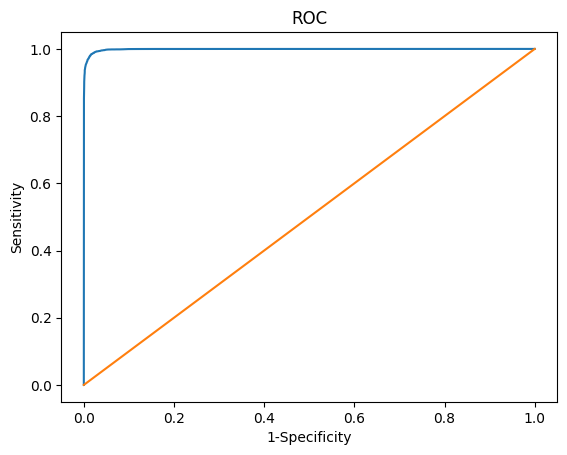

In [432]:
# plot ROC

plt.figure()
plt.plot(1-specificity, sensitivity)
plt.plot(thresholds, thresholds)

plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC')

plt.show()

In [433]:
# best threshold

max_sum = 0
best_threshold = 1000

for i in range(len(thresholds)):
  if sensitivity[i] + specificity[i] > max_sum:
    max_sum = sensitivity[i] + specificity[i]
    best_threshold = thresholds[i]

print('The best threshold is: ' + str(best_threshold))
print('The best sensitivity and specificity sum is: ' + str(max_sum))

The best threshold is: 0.52
The best sensitivity and specificity sum is: 1.9677941176470588


## Confusion matrix

In [434]:
predicte = Classify_For_Specific_Threshold(probability_class_1, best_threshold)
cm = confusion_matrix(y, predicte)
cm = cm / cm.sum(axis=1) * 100
print(cm)

[[98.39705882  1.60294118]
 [ 1.61764706 98.38235294]]
